Textarea(value='Receiver is set to: X axis\nSample length set to 16 kS\nSample length set to 32 kS\nSet ADC ga…

Dropdown(description='Comport', index=1, options=('select comport', 'COM4 \tTEI0023A - 2 MS \tUSB VID:PID=0403…

SelectionSlider(description='Samples [kS]', options=('16', '32', '64', '128', '256', '512', '1024'), value='16…

Button(description='Capture FFT data', style=ButtonStyle())

Button(description='Download plot data', disabled=True, style=ButtonStyle())

Dropdown(description='Receiver Axis', index=1, options=('Select axis', 'X axis', 'Y axis', 'Z axis'), value='X…

<IPython.core.display.Javascript object>


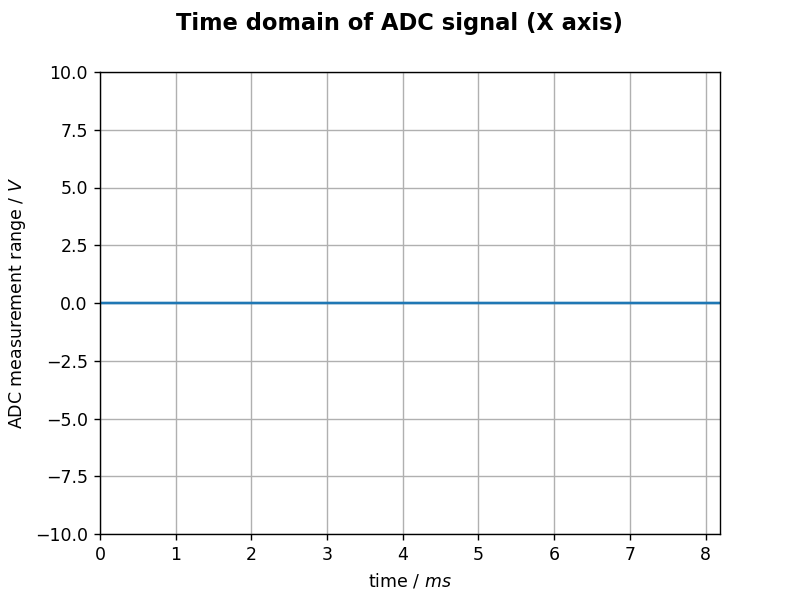

<IPython.core.display.Javascript object>


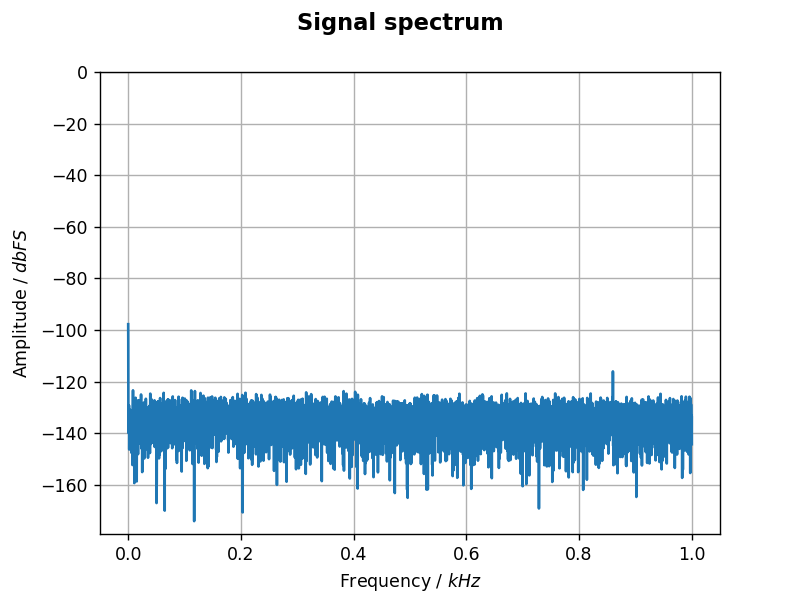

In [30]:
"""
Author: Trenz Electronic GmbH / Kilian Jahn 27.09.2019 - edited 25.02.2020
Edited within the Python version:   3.7.3

This notebook is an example on using the ADC of the Trenz modules TEI0015, TEI0016
and TEI0023. The notebook features data acquisition, conversion to standard integer 
and Fourier transformation.
Further explonations are available in the Trenz Electronic wiki for the above
mentioned modules.
"""

import sys  # Reading installed python Version
import copy # Deep coping of module parameters

import serial  # Serial/Comport connection
import serial.tools.list_ports # Reading available comports

from matplotlib import pyplot as plt  # Interactive Graphs
import numpy as np # Change values of collected data easily

import ipywidgets as widgets  # GUI
from IPython.display import clear_output  # Clearing the GUI / plots

import TEI00xyCodeModule # Functions for collecting and analysing ADC data

import pandas as pd # Save data as csv file

# Global variables------------------------------------------------------------------------------------------

# ############## Set default values for comport and module here ##############
#
# No default comport = 'COMx' -> manually select port, if desired comport is for example 4 set to 'COM4'
comport = 'COMx'
# 
#
# ############################################################################


# Module parameters
TEI0015 = {
    'ID': 1, 'module': 'TEI0015 - 2 MS',
    'ADCsamplingRate' : 2000000, 'AdcMaxInt': 131072, 'ADCexceedTreshold' : 131052,
    'gain 1' : 1, 'gain 2' : 2, 'gain 4' : 4, 'gain 8' : 8,
    'gainList' : [1, 2, 4, 8]
}
TEI0016A = {
    'ID': 2, 'module': 'TEI0016A - 0.5 MS',
    'ADCsamplingRate': 500000, 'AdcMaxInt': 32768, 'ADCexceedTreshold': 32763,
    'gain 1': 1, 'gain 2': 2, 'gain 4': 4, 'gain 8': 8,
    'gainList': [1, 2, 4, 8]
}
TEI0016B = {
    'ID': 3, 'module': 'TEI0016B - 1 MS',
    'ADCsamplingRate': 1000000, 'AdcMaxInt': 32768, 'ADCexceedTreshold': 32763,
    'gain 1': 1, 'gain 2': 2, 'gain 4': 4, 'gain 8': 8,
    'gainList': [1, 2, 4, 8]
}
TEI0023A = {
    'ID': 4, 'module': 'TEI0023A - 2 MS',
    'ADCsamplingRate': 2000000, 'AdcMaxInt': 131072, 'ADCexceedTreshold': 131052,
    'gain 0.25': 1, 'gain 0.5': 2, 'gain 1': 3, 'gain 2': 4, 'gain 4': 5, 'gain 8': 6, 'gain 16': 7,
    'gainList': [0.25, 0.5, 1, 2, 4, 8, 16]
}
# The module, to which the Notebook is connected, is stored together with its settings as the fifth element
modules = [TEI0015, TEI0016A, TEI0016B, TEI0023A]



# GUI function ---------------------------------------------------------------------------------------------
#def downloadPlotData(marker):
#    if moduleParameters('initDone') == True:
 #       text = moduleParameters('downloadData', marker)
#        messageTextBoxAdd(text)

    
def sliderSamples(samples):
    text = moduleParameters('updateSamples', samples)
    messageTextBoxAdd(text)

    
def squareWaveSignal(marker):
    if moduleParameters('axisSelected') == '':
        text = moduleParameters('updateGen', marker)
        messageTextBoxAdd(text)


def messageTextBoxAdd(text):
    global handleMessageBox
    handleMessageBox.value = str(text) + "\n" + handleMessageBox.value


def sliderGain(gain):
    # TEI0023 modules have a slider beginning with 0.25, therefore during setup inside
    # moduleParameters(), this function is called two times. Reduction to just one call.    
    if moduleParameters('axisSelected') == '':
        text = moduleParameters('updateGain', gain)
        messageTextBoxAdd(text)

def selectRxAxis(selection):
    if moduleParameters('initDone') == True:
        text = moduleParameters('selectAxis', selection)
        messageTextBoxAdd(text)
        handleButton.disabled = False
    
def selectComport(selection):
    global handleGain
    global modules
    # Cut from selection the comport
    for index, character in enumerate(selection):
        if character == ' ':
            comport = str(selection[:int(index)])
            break    
    textBoolId = moduleParameters('setup', comport)
    messageTextBoxAdd(textBoolId[0])
    
    if textBoolId[0][0:12] != 'No module on': # Only if a moudule is connected
        handleGain.options = moduleParameters('gainList')
        handleGain.value = 2 # Force a function call to ensure that gain will be set to 1
        modules[4]['initDone'] = True
        handleGain.value = 1 
        handleSquareWave.value = False # If the user switches between modules
       # handleDownload.value = False # If the user switches between modules
    # Enable or disable the GUI
    handleGain.disabled = textBoolId[1]
    handleSamples.disabled = textBoolId[1]
    handleSquareWave.disabled = textBoolId[1]
    handleDownloadButton.disabled = True
    handleButton.disabled = True
    handleRxAxis.disabled = textBoolId[1]
    
    
def moduleParameters(key, optionalArgument = None):
    global modules
    global comport
    
   # global axisSelected
   # global downloadButton
    # Connecting to a module, store the connected module and its settings as fifth element in modules[]
    if key == 'setup': 
        id = TEI00xyCodeModule.getModuleId(optionalArgument)
        if id > 0 and id < 5:
            modulesTemp = copy.deepcopy(modules[id - 1])
            modulesTemp.update({'comPort': optionalArgument, 'gainCommand': 0, 'gainValue': 0, 'plotScale': 10,
                                'samplesActual': 16 , 'genStatus': False, 'axisSelected': '', 'initDone': False})
            if len(modules) > 4: # If the user switches between modules, delete the previous one
                modules.pop()
            modules.append(modulesTemp)
            if comport != 'COMx': # When a default comport / module is set
                comport = 'COMx'
                return ['Default module on ' + optionalArgument + ' selected / ' + modules[4]['module'], False]
            else:
                messageTextBoxAdd(optionalArgument)
                #axisSelected = False
                return ['Connected to ' + optionalArgument + ' / ' + modules[4]['module'], False]
        else:
            return ['No module on ' + optionalArgument, True] # Not a connection to a module
       
        # Can't download data unless user start the FFT capture
       # downloadButton = False
         
    if key == 'updateGain': # When the gain is changed
        try:
            opaGain = float(optionalArgument)
            # Define plot limits acording to the gain. Apply hardware input limit of 10 V
            inputRange = 10 / opaGain
            if inputRange >= 10:
                inputRange = 10
            temp = modules[4]['gain ' + str(optionalArgument)]            
            TEI00xyCodeModule.sendCommand(modules[4]['comPort'], str(temp)) # Save value
            modules[4]['gainCommand'] = temp
            modules[4]['gainValue'] = optionalArgument
            modules[4]['plotScale'] = inputRange
            return "Set ADC gain to " + str(opaGain) + " / measurement range is +/- " + str(inputRange) + " V"
        except:
            return "Error setting gain"
        
    if key == 'updateGen': # When the status of the square wave generator is changed
        try:
            if optionalArgument == True:
                TEI00xyCodeModule.sendCommand(modules[4]['comPort'], 'F')
                text = 'Square wave generator ON [10 kHz, +/- 3.3 V]'
            else:
                TEI00xyCodeModule.sendCommand(modules[4]['comPort'], 'f')
                text = 'Square wave generator OFF [10 kHz, +/- 3.3 V]'
            modules[4]['genStatus'] = optionalArgument # Save status
        except:
            text = 'Error, changing status square wave signal'
        return text
    
    if key == 'updateSamples':  # When the length of samples is changed
        modules[4]['samplesActual'] = int(optionalArgument) # Save value
        return 'Sample length set to ' + str(optionalArgument) + ' kS'
    
    if key == 'selectAxis':
        global axis
        try:
            modules[4]['rxAxis'] = optionalArgument # Save status
            axis = str(optionalArgument)
            return "Receiver is set to: " + str(axis)
        except:
            return "Error setting axis"
            
   # if key == 'downloadData': # When the status of the download data is changed
    #    try:
     #       if optionalArgument == True:
     #           TEI00xyCodeModule.sendCommand(modules[4]['comPort'], 'F')
     #           text = 'Downloading ....'
      #      else:
      #          TEI00xyCodeModule.sendCommand(modules[4]['comPort'], 'f')
      #          text = 'Not Downloading....'
      #      modules[4]['genStatus'] = optionalArgument # Save status
     #   except:
     #       text = 'Error, changing status of download data'
     #   return text
    
    if key == 'setttingCommit': # Before every (perform)DataAcquisition(FFT) the setting is reapplied
        TEI00xyCodeModule.sendCommand(modules[4]['comPort'], modules[4]['gainCommand'])
        if modules[4]['genStatus'] == True:
            TEI00xyCodeModule.sendCommand(modules[4]['comPort'], 'F')
        else:
            TEI00xyCodeModule.sendCommand(modules[4]['comPort'], 'f')        
        return None
        
    else:
        if optionalArgument == None:
            temp = modules[4][key]
        else:
            temp = modules[optionalArgument][key]
        return temp

# This function contains all the code for downloading the data
def downloadPlotData (handleButton):
    
    messageTextBoxAdd("Download done")
    
# This function contains all the code for data collection from the module and plotting it
def performDataAcquisitionFFT(handleButton):
    global handleMessageBox
    global adcSignals
    global duration
    
   # downloadButton = True
    clear_output() # Clear the plots from a previous program run and restore the GUI
    display(handleMessageBox, handleSerial, handleBox, handleSamples, handleButton, handleDownloadButton, handleRxAxis)    
    
    try:
        # If the module lost ist gain and generator setting
        #moduleParameters('setttingCommit')        
        # Collect  adc data and convert to voltage
        adcSignals = TEI00xyCodeModule.dataCollect(moduleParameters('comPort'), moduleParameters('samplesActual'), 
                                                   moduleParameters('ID'))
        # Activating interactive graph plots
        %matplotlib notebook
        plt.ion()       
        
        # Process data for plotting, convert from samples to Milli Seconds
        adcSignalslength = len(adcSignals[0])
        periode = 1000 * 1 / moduleParameters('ADCsamplingRate')
        duration = np.arange(0, adcSignalslength * periode, periode)
        # Scale the signal acording to the gain
        adcSignals[0][:] = [x / moduleParameters('gainValue') for x in adcSignals[0]]
        # Plot the adc voltage data        
        scale = float(moduleParameters('plotScale'))
        handlePlot = TEI00xyCodeModule.plottingGraphs(0, 'Time domain of ADC signal (' + str(axis) + ')' , 'time / $ms$', 
                        'ADC measurement range / $V$', [duration, adcSignals[0]], [0, duration[-1], -scale, scale])
        # Check if measurment limits are exceeded
        adcLimitsExceeded = TEI00xyCodeModule.signalLimitsExceed(adcSignals[2], moduleParameters('ADCexceedTreshold'))
        if adcLimitsExceeded > 10:
            text = 'WARNING - ' + str(adcLimitsExceeded) + ' samples exceed measurement range'
            handleAxes = plt.gca()            
            handlePlot.text(0.5, 0.5, text, color = 'red', backgroundcolor='white',
                     transform = handleAxes.transAxes, horizontalalignment = 'center')
            messageTextBoxAdd("WARNING - INPUTSIGNAL EXCEDDS MEASURMENT LIMITS !")
        messageTextBoxAdd("Data captured")
        
        # Convert adc data to a FFT. Return value is: [frequencies, fftSignal]
        temp = TEI00xyCodeModule.performeFFTdbFS(moduleParameters('ADCsamplingRate'), adcSignals[1])        
        # Process data for plotting, convert to Kilo Hertz
        minimum = min(temp[1])
        temp[0][:] = [y / 1000 for y in temp[0]]
        # Plot the FFT
        TEI00xyCodeModule.plottingGraphs(1, 'Signal spectrum', 'Frequency / $kHz$', 'Amplitude / $dbFS$', 
                                         temp, [0, 0, int(minimum * 1.01-3.5), 0])
        messageTextBoxAdd("Fast Fourier Transformation done")
        
        #User can download data after FFT capture
        handleDownloadButton.disabled = False 
       # handleRxAxis.disabled = True 
    except:
        messageTextBoxAdd("Runtime error performing adc data collection")
    
    
# Programm initialisation / define GUI----------------------------------------------------------------------

handleGain = widgets.SelectionSlider(description='Gain linear', options=['1', '2', '4', '8'], disabled = True)
handleSquareWave = widgets.Checkbox(value=False, description='Activate square wave signal', disabled = True)
handleSamples = widgets.SelectionSlider(description='Samples [kS]', 
                        options=['16', '32', '64', '128', '256', '512', '1024'], disabled = True)
handleButton = widgets.Button(description="Capture FFT data", disabled = True)

handleDownloadButton = widgets.Button(description='Download plot data', disabled = True)

handleButton.on_click(performDataAcquisitionFFT)
handleDownloadButton.on_click(downloadPlotData)


optionList = ['select comport']
ports = serial.tools.list_ports.comports() # Gather available comports
for port, desc, hwid in sorted(ports):
    if desc[:15] == 'USB Serial Port': # Modules, and other devices, desc beginns with this
        temp = TEI00xyCodeModule.getModuleId(port)
        if temp > 0 and temp < 5: # Range of module id's
            desc = moduleParameters('module', temp - 1) # Replace OS desc with modules name
            if port == comport: # If default comport set, store its index
                comport = len(optionList)
                firstText = '' # Suppress non default comport message
    temp = port + " \t" + desc + " \t" + hwid
    optionList.append(temp)
handleSerial = widgets.Dropdown(options = optionList, description = 'Comport')

axisList = ['Select axis', 'X axis', 'Y axis', 'Z axis']
handleRxAxis = widgets.Dropdown(options = axisList, description = 'Receiver Axis', disabled = True)

# Bind GUI elements to their functions
widgets.interactive(selectComport, selection = handleSerial)
widgets.interactive(sliderGain, gain = handleGain)
widgets.interactive(sliderSamples, samples = handleSamples)
widgets.interactive(squareWaveSignal, marker = handleSquareWave)
widgets.interactive(selectRxAxis, selection = handleRxAxis)

versionFound = sys.version # Get installed python version
for index, character in enumerate(versionFound): # Cut string to just the version number 
    if character == ' ':
        versionFound = str(versionFound[:int(index)])
        break
handleMessageBox = widgets.Textarea('Python version ' + versionFound + ' found' 
                                    + ' / minimum version 3.7.3 required', 
                                    layout=widgets.Layout(width='50%', height='100%'))

# Show the GUI
handleBox = widgets.HBox([handleGain, handleSquareWave])
display(handleMessageBox, handleSerial, handleBox, handleSamples, handleButton, handleDownloadButton, handleRxAxis)

# If a default comport is set, initialize the Notebooks GUI with it
if type(comport) == str and comport != 'COMx': # False default comport set
    messageTextBoxAdd('Select comport / module\nNo module found on default comport')
    comport = 'COMx'
elif type(comport) == int: # Existing default comport
    handleSerial.index = comport
else: # No default comport
    messageTextBoxAdd('Select comport / module')
